# Testing DEMV on _Law School Admissions_ (LAW) dataset

- Unprivileged group: `gender=1 && race=1`
- sex: 1 female, 0 male
- race: 0 white, 1 non white

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn
#patch_sklearn()

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [2]:
data = pd.read_csv('data2/bar_pass_prediction.csv', index_col='Unnamed: 0')
col_to_drop = ['ID', 'decile1b', 'decile3', 'decile1', 'cluster', 'bar1', 'bar2',
               'sex', 'male', 'race1', 'race2', 'other', 'asian', 'black', 'hisp', 'bar', 'index6040', 'indxgrp', 'indxgrp2', 'dnn_bar_pass_prediction', 'grad', 'bar1_yr', 'bar2_yr', 'ugpa']
data.drop(col_to_drop, axis=1, inplace=True)
data.loc[data['Dropout'] == 'NO', 'Dropout'] = 0
data.loc[data['Dropout'] == 'YES', 'Dropout'] = 1
data.dropna(inplace=True)
data.loc[data['gender']=='female', 'gender'] = 1
data.loc[data['gender'] == 'male', 'gender'] = 0
data.loc[data['race']==7.0, 'race'] = 0
data.loc[data['race'] != 0, 'race'] = 1
data['gpa'] = pd.qcut(data['gpa'], 3, labels=['a','b','c'])
enc = LabelEncoder()
data['gpa'] = enc.fit_transform(data['gpa'].values)
data


,race,lsat,zfygpa,DOB_yr,zgpa,fulltime,fam_inc,age,gender,parttime,Dropout,pass_bar,tier,gpa
0,0.0,44.0,1.33,69.0,1.88,1.0,5.0,-62.0,1,0.0,0,1.0,4.0,2
1,0.0,29.0,-0.11,69.0,-0.57,1.0,4.0,-62.0,1,0.0,0,1.0,2.0,2
2,0.0,36.0,-0.64,65.0,-1.12,1.0,1.0,-58.0,0,0.0,0,1.0,3.0,2
3,0.0,39.0,0.34,58.0,-0.49,1.0,4.0,-51.0,0,0.0,0,1.0,3.0,2
4,0.0,48.0,1.02,68.0,0.76,1.0,4.0,-61.0,0,0.0,0,1.0,5.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,1.0,26.5,-0.58,64.0,-1.49,1.0,2.0,-62.0,0,0.0,0,0.0,1.0,0
22403,1.0,19.7,-0.64,64.0,-1.36,1.0,3.0,-57.0,0,0.0,0,0.0,1.0,0
22404,1.0,36.0,0.41,66.0,0.80,2.0,3.0,-59.0,0,1.0,0,1.0,3.0,0
22405,0.0,44.0,1.88,58.0,1.42,2.0,3.0,-51.0,0,1.0,0,1.0,3.0,0


In [3]:
protected_group = {'race': 1, 'gender': 1}
label = 'gpa'
sensitive_features=['race', 'gender']
positive_label = 2

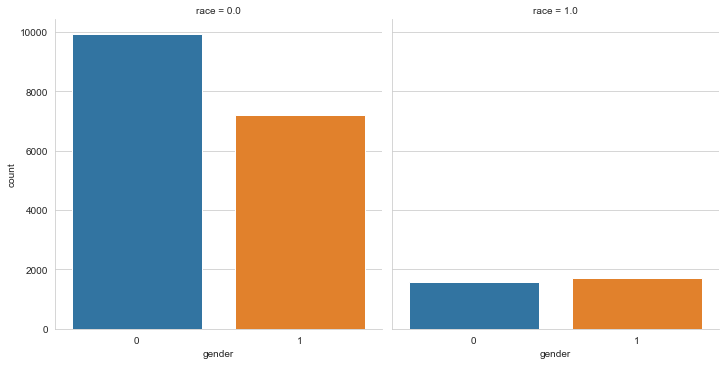

In [4]:
sns.catplot(data=data, x='gender', col='race', kind='count')
plt.show()

## Bias Metrics

### Logistic regression

In [5]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)

In [6]:
model, lr_metrics  = cross_val(pipeline, data, label, protected_group, sensitive_features=sensitive_features, positive_label=positive_label)
print_metrics(lr_metrics)

Equalized odds:  0.2  +-  0.027
Disparate impact:  0.502  +-  0.068
Zero one loss:  0.164  +-  0.029
Accuracy score:  0.521  +-  0.01


## DEMV Metrics

In [7]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression

In [8]:
model, lr_demv = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_features, debiaser=demv, positive_label=2)
print_metrics(lr_demv)

Equalized odds:  0.145  +-  0.061
Disparate impact:  0.886  +-  0.075
Zero one loss:  0.159  +-  0.021
Accuracy score:  0.512  +-  0.011


## DEMV Evaluation

In [9]:
demv.get_iters()

618

In [10]:
metrics = eval_demv(200, demv.get_iters(), data.copy(), pipeline, label, protected_group, sensitive_features, positive_label=2)

##  Blackbox Postprocessing

In [11]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.6103  0.8538
1  0.0011  0.0000
2  0.2023  0.4712

1
      fpr     tpr
0  0.3468  0.6297
1  0.0485  0.0579
2  0.4068  0.6667


And loss is 0.4905


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.6071  0.8538
1  0.0000  0.0034
2  0.2023  0.4916

1
      fpr     tpr
0  0.3636  0.6297
1  0.0420  0.0633
2  0.3966  0.6779


And loss is 0.4826

[0.56501536 0.14285281 0.29213182]
[0.45466513 0.11835433 0.42698055]
[0.33643101 0.08505984 0.57850915]
[0.56501536 0.15141699 0.28356764]
[0.46459777 0.11835433 0.4170479 ]
[0.33501738 0.08647347 0.57850915]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.6145  0.8538
1  0.0011  0.0000
2  0.1724  0.4712

1
      fpr     tpr
0  0.3267  0.6297
1  0.0485  0.0340
2  0.3952  0.6667


And loss is 0.4385

[0.69575658 0.01918294 0.28506049]
[0.61421844 0.03231522 0.35346634]
[0.42832549 0.06183393 0.50984058]
[0.69575658 0.04620927 0.25803416]
[0.56811165 0.03231522 0.39957314]


##  Plot

In [12]:
df = prepareplots(metrics,'law')

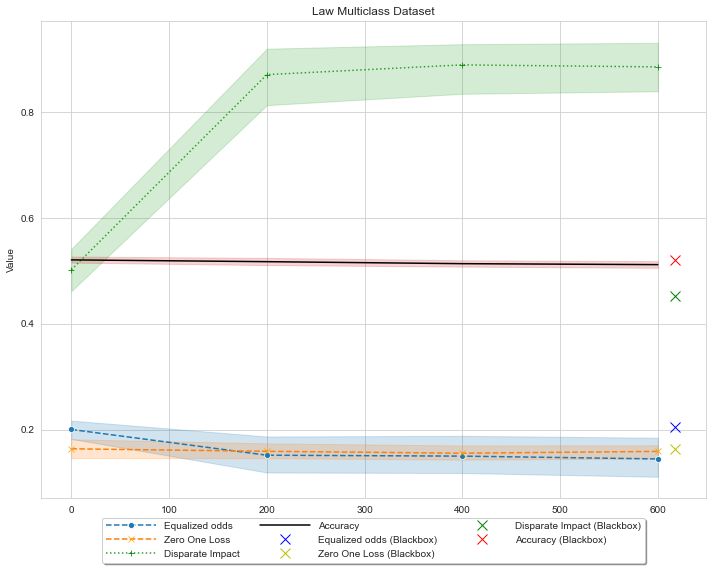

In [13]:
points = preparepoints(blackboxmetrics, demv.get_iters())

plot_metrics_curves(df, points, 'Law Multiclass Dataset')


In [14]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 20427
Unprivileged group size: 1720
Percentage of unprivileged group: 8.42022812943653
Number of iterations: 618


In [15]:
blackboxmetrics

{'eq_odds': [[0.2196825396825397],
  [0.18206072517541605],
  [0.40550192292598697],
  [0.1644280181009357],
  [0.21886816120997077],
  [0.1541818181818182],
  [0.13283570721303983],
  [0.2122315599247247],
  [0.23741600101432736],
  [0.12773638704930096]],
 'zero_one_loss': [[0.2072463768115942],
  [0.1230299694801621],
  [0.1722239374292477],
  [0.1734246291467353],
  [0.11842802628789484],
  [0.15421821058688145],
  [0.14887139887139877],
  [0.1710031347962382],
  [0.1604887282739632],
  [0.2104631710573006]],
 'disp_imp': [[0.37564499484004127],
  [0.29709436927847754],
  [0.6178479143595422],
  [0.394464609800363],
  [0.3584627881003148],
  [0.40178571428571425],
  [0.5906981386296721],
  [0.5501797973193855],
  [0.3955445497585366],
  [0.5414156251556042]],
 'acc': [[0.5100342633382281],
  [0.5330396475770925],
  [0.5389133627019089],
  [0.5286343612334802],
  [0.5232501223690651],
  [0.5212922173274597],
  [0.5066079295154186],
  [0.5186092066601371],
  [0.5190989226248776],
  [

In [16]:
save_metrics('blackbox', 'law', blackboxmetrics)